In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('D:/Major Project/Dataset/Dynamics/A1237_40deg.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24098 entries, 0 to 24097
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Current(A)      24098 non-null  float64
 1   Voltage(V)      24098 non-null  float64
 2   Temperature(C)  24098 non-null  float64
 3   OCV             24098 non-null  float64
 4   SOC             24098 non-null  float64
dtypes: float64(5)
memory usage: 941.5 KB


In [5]:
data.head()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
0,0.000000,2.793785,36.862907,2.793785,33.0
1,-1.099373,2.576188,36.893200,2.565194,14.0
2,-1.099373,2.535869,36.953785,2.524875,10.0
3,-1.099185,2.487241,37.027802,2.476249,6.0
4,-1.099373,2.422608,36.923492,2.411614,1.0


In [6]:
data.describe()

,Current(A),Voltage(V),Temperature(C),OCV,SOC
count,24098.000000,24098.000000,24098.000000,24098.000000,24098.000000
mean,-0.386893,3.201949,41.877334,3.198080,66.510042
std,0.936510,0.187159,0.451515,0.194815,16.242099
min,-3.849407,2.413067,36.862907,2.401351,0.000000
25%,-0.895951,3.118796,41.738197,3.111034,59.000000
50%,-0.360069,3.219747,41.892426,3.216171,68.000000
75%,0.000378,3.306540,42.076561,3.307395,76.000000
max,2.061073,3.591848,42.886879,3.599771,100.000000


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
x = data.iloc[:,:-2]
y = data.iloc[:,-1]

In [9]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [10]:
x = x.reshape(24098,3,1)

In [11]:
x

array([[[0.65128501],
        [0.32297662],
        [0.        ]],

       [[0.46528109],
        [0.13838128],
        [0.00502866]],

       [[0.46528109],
        [0.10417753],
        [0.01508598]],

       ...,

       [[0.50951791],
        [0.05900793],
        [0.88271903]],

       [[0.47735724],
        [0.02141008],
        [0.86548442]],

       [[0.65128501],
        [0.18929502],
        [0.86048173]]])

In [12]:
y = np.array(y).reshape(24098,1)

In [13]:
y

array([[33.],
       [14.],
       [10.],
       ...,
       [ 6.],
       [ 2.],
       [20.]])

In [14]:
train_input, test_input, train_soc, test_soc = train_test_split(x,y,test_size=0.2, random_state=42)

In [15]:
for i in range(len(train_soc)):
    if train_soc[i] == 0:
        train_soc[i] = 1

In [16]:
for i in range(len(test_soc)):
    if test_soc[i] == 0:
        test_soc[i] = 1

In [17]:
train_input.shape

(19278, 3, 1)

In [18]:
test_input.shape

(4820, 3, 1)

In [19]:
train_soc.shape

(19278, 1)

In [20]:
test_soc.shape

(4820, 1)

In [21]:
from keras.models import Sequential
from keras.layers import  Dense, RepeatVector, TimeDistributed, GRU,Flatten
from keras.optimizers import Adam,SGD,RMSprop

In [22]:
# Define the model
model = Sequential()

# Encoder
model.add(Dense(16, input_shape=(3,1),activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Flatten())

# Repeat the context vector to be the input for the decoder
model.add(RepeatVector(1))

# Decoder
model.add(GRU(64, return_sequences=True,activation='sigmoid'))
model.add(GRU(32, return_sequences=True,activation='sigmoid'))
model.add(GRU(16, return_sequences=True,activation='sigmoid'))
model.add(TimeDistributed(Dense(1, activation='linear')))  # Output sequence for regression

In [23]:
# Compile the model with optimizer and loss function
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [24]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3, 16)             32        
                                                                 
 dense_1 (Dense)             (None, 3, 32)             544       
                                                                 
 dense_2 (Dense)             (None, 3, 64)             2112      
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 192)            0         
 r)                                                              
                                                                 
 gru (GRU)                   (None, 1, 64)             49536     
                                                        

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,mean_absolute_percentage_error
import time

In [26]:
# Train the model
a1 = time.time()
history = model.fit(train_input, train_soc, epochs=500, batch_size=256,validation_split=0.05)
a2 = time.time()
a = a2-a1

Epoch 1/500
72/72 [==============================] - 5s 15ms/step - loss: 4550.6611 - mae: 65.4552 - val_loss: 4327.8369 - val_mae: 63.9366
Epoch 2/500
72/72 [==============================] - 0s 6ms/step - loss: 4275.3926 - mae: 63.3262 - val_loss: 4184.2148 - val_mae: 62.8047
Epoch 3/500
72/72 [==============================] - 0s 6ms/step - loss: 4172.2432 - mae: 62.5093 - val_loss: 4101.1763 - val_mae: 62.1415
Epoch 4/500
72/72 [==============================] - 0s 6ms/step - loss: 4095.3232 - mae: 61.8925 - val_loss: 4028.7537 - val_mae: 61.5572
Epoch 5/500
72/72 [==============================] - 0s 6ms/step - loss: 4025.3267 - mae: 61.3273 - val_loss: 3960.9783 - val_mae: 61.0063
Epoch 6/500
72/72 [==============================] - 0s 6ms/step - loss: 3958.9241 - mae: 60.7857 - val_loss: 3895.8765 - val_mae: 60.4725
Epoch 7/500
72/72 [==============================] - 0s 6ms/step - loss: 3894.8193 - mae: 60.2582 - val_loss: 3832.6882 - val_mae: 59.9499
Epoch 8/500
72/72 [=======

72/72 [==============================] - 0s 6ms/step - loss: 1573.7058 - mae: 36.8602 - val_loss: 1529.5743 - val_mae: 36.4421
Epoch 60/500
72/72 [==============================] - 0s 7ms/step - loss: 1542.6848 - mae: 36.4597 - val_loss: 1498.8085 - val_mae: 36.0335
Epoch 61/500
72/72 [==============================] - 0s 6ms/step - loss: 1512.0934 - mae: 36.0605 - val_loss: 1468.4559 - val_mae: 35.6298
Epoch 62/500
72/72 [==============================] - 0s 6ms/step - loss: 1481.9283 - mae: 35.6638 - val_loss: 1438.5841 - val_mae: 35.2277
Epoch 63/500
72/72 [==============================] - 0s 6ms/step - loss: 1452.2046 - mae: 35.2679 - val_loss: 1409.1078 - val_mae: 34.8278
Epoch 64/500
72/72 [==============================] - 0s 6ms/step - loss: 1422.9166 - mae: 34.8750 - val_loss: 1380.0464 - val_mae: 34.4294
Epoch 65/500
72/72 [==============================] - 0s 7ms/step - loss: 1394.0643 - mae: 34.4829 - val_loss: 1351.4567 - val_mae: 34.0328
Epoch 66/500
72/72 [=============

72/72 [==============================] - 1s 7ms/step - loss: 429.0386 - mae: 17.6095 - val_loss: 398.0355 - val_mae: 16.8930
Epoch 119/500
72/72 [==============================] - 1s 9ms/step - loss: 420.3816 - mae: 17.3830 - val_loss: 389.5552 - val_mae: 16.6593
Epoch 120/500
72/72 [==============================] - 1s 9ms/step - loss: 412.0334 - mae: 17.1639 - val_loss: 381.3925 - val_mae: 16.4297
Epoch 121/500
72/72 [==============================] - 1s 9ms/step - loss: 403.9724 - mae: 16.9468 - val_loss: 373.5474 - val_mae: 16.2028
Epoch 122/500
72/72 [==============================] - 1s 8ms/step - loss: 396.2127 - mae: 16.7347 - val_loss: 365.9509 - val_mae: 15.9841
Epoch 123/500
72/72 [==============================] - 1s 8ms/step - loss: 388.7288 - mae: 16.5290 - val_loss: 358.6150 - val_mae: 15.7694
Epoch 124/500
72/72 [==============================] - 1s 8ms/step - loss: 381.5365 - mae: 16.3260 - val_loss: 351.5865 - val_mae: 15.5574
Epoch 125/500
72/72 [====================

Epoch 177/500
72/72 [==============================] - 1s 8ms/step - loss: 265.6331 - mae: 12.1025 - val_loss: 240.0109 - val_mae: 11.3147
Epoch 178/500
72/72 [==============================] - 1s 7ms/step - loss: 265.6125 - mae: 12.0975 - val_loss: 239.9945 - val_mae: 11.3114
Epoch 179/500
72/72 [==============================] - 1s 9ms/step - loss: 265.5956 - mae: 12.0922 - val_loss: 239.9814 - val_mae: 11.3082
Epoch 180/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5831 - mae: 12.0882 - val_loss: 239.9725 - val_mae: 11.3056
Epoch 181/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5737 - mae: 12.0862 - val_loss: 239.9668 - val_mae: 11.3035
Epoch 182/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5667 - mae: 12.0835 - val_loss: 239.9636 - val_mae: 11.3021
Epoch 183/500
72/72 [==============================] - 1s 8ms/step - loss: 265.5599 - mae: 12.0802 - val_loss: 239.9591 - val_mae: 11.2997
Epoch 184/500
72/72 [======

Epoch 236/500
72/72 [==============================] - 1s 8ms/step - loss: 265.5481 - mae: 12.0646 - val_loss: 239.9551 - val_mae: 11.2908
Epoch 237/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5491 - mae: 12.0667 - val_loss: 239.9554 - val_mae: 11.2905
Epoch 238/500
72/72 [==============================] - 0s 7ms/step - loss: 265.5494 - mae: 12.0644 - val_loss: 239.9563 - val_mae: 11.2895
Epoch 239/500
72/72 [==============================] - 1s 8ms/step - loss: 265.5502 - mae: 12.0639 - val_loss: 239.9565 - val_mae: 11.2893
Epoch 240/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5501 - mae: 12.0638 - val_loss: 239.9551 - val_mae: 11.2909
Epoch 241/500
72/72 [==============================] - 1s 8ms/step - loss: 265.5504 - mae: 12.0620 - val_loss: 239.9562 - val_mae: 11.2896
Epoch 242/500
72/72 [==============================] - 1s 7ms/step - loss: 265.5501 - mae: 12.0612 - val_loss: 239.9565 - val_mae: 11.2893
Epoch 243/500
72/72 [======

72/72 [==============================] - 1s 9ms/step - loss: 6.2442 - mae: 0.9502 - val_loss: 6.0701 - val_mae: 0.9021
Epoch 297/500
72/72 [==============================] - 1s 9ms/step - loss: 5.8863 - mae: 0.9264 - val_loss: 5.7288 - val_mae: 0.8724
Epoch 298/500
72/72 [==============================] - 1s 9ms/step - loss: 5.5369 - mae: 0.8950 - val_loss: 5.4143 - val_mae: 0.8518
Epoch 299/500
72/72 [==============================] - 1s 8ms/step - loss: 5.2158 - mae: 0.8746 - val_loss: 5.1272 - val_mae: 0.8551
Epoch 300/500
72/72 [==============================] - 1s 10ms/step - loss: 4.9148 - mae: 0.8599 - val_loss: 4.8495 - val_mae: 0.8445
Epoch 301/500
72/72 [==============================] - 1s 9ms/step - loss: 4.6195 - mae: 0.8374 - val_loss: 4.5762 - val_mae: 0.8281
Epoch 302/500
72/72 [==============================] - 1s 10ms/step - loss: 4.3448 - mae: 0.8194 - val_loss: 4.2720 - val_mae: 0.7652
Epoch 303/500
72/72 [==============================] - 1s 12ms/step - loss: 4.060

72/72 [==============================] - 1s 8ms/step - loss: 0.1739 - mae: 0.2898 - val_loss: 0.2159 - val_mae: 0.2981
Epoch 358/500
72/72 [==============================] - 1s 8ms/step - loss: 0.1657 - mae: 0.2855 - val_loss: 0.2241 - val_mae: 0.3144
Epoch 359/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1700 - mae: 0.2918 - val_loss: 0.2038 - val_mae: 0.2953
Epoch 360/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1699 - mae: 0.2955 - val_loss: 0.2251 - val_mae: 0.3207
Epoch 361/500
72/72 [==============================] - 1s 8ms/step - loss: 0.1678 - mae: 0.2954 - val_loss: 0.2010 - val_mae: 0.2999
Epoch 362/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1581 - mae: 0.2895 - val_loss: 0.1962 - val_mae: 0.2993
Epoch 363/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1437 - mae: 0.2765 - val_loss: 0.1740 - val_mae: 0.2779
Epoch 364/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1431 -

72/72 [==============================] - 1s 9ms/step - loss: 0.1055 - mae: 0.2686 - val_loss: 0.1005 - val_mae: 0.2590
Epoch 419/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1108 - mae: 0.2739 - val_loss: 0.1011 - val_mae: 0.2614
Epoch 420/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1031 - mae: 0.2652 - val_loss: 0.1013 - val_mae: 0.2625
Epoch 421/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1035 - mae: 0.2667 - val_loss: 0.0957 - val_mae: 0.2562
Epoch 422/500
72/72 [==============================] - 1s 10ms/step - loss: 0.1026 - mae: 0.2652 - val_loss: 0.1085 - val_mae: 0.2668
Epoch 423/500
72/72 [==============================] - 1s 10ms/step - loss: 0.1044 - mae: 0.2682 - val_loss: 0.1494 - val_mae: 0.3135
Epoch 424/500
72/72 [==============================] - 1s 10ms/step - loss: 0.1099 - mae: 0.2732 - val_loss: 0.0939 - val_mae: 0.2550
Epoch 425/500
72/72 [==============================] - 1s 10ms/step - loss: 0.09

72/72 [==============================] - 1s 11ms/step - loss: 0.1002 - mae: 0.2651 - val_loss: 0.1082 - val_mae: 0.2699
Epoch 480/500
72/72 [==============================] - 1s 8ms/step - loss: 0.1097 - mae: 0.2738 - val_loss: 0.0902 - val_mae: 0.2518
Epoch 481/500
72/72 [==============================] - 1s 9ms/step - loss: 0.0969 - mae: 0.2617 - val_loss: 0.1011 - val_mae: 0.2639
Epoch 482/500
72/72 [==============================] - 1s 10ms/step - loss: 0.0975 - mae: 0.2618 - val_loss: 0.0900 - val_mae: 0.2534
Epoch 483/500
72/72 [==============================] - 1s 9ms/step - loss: 0.0985 - mae: 0.2628 - val_loss: 0.0864 - val_mae: 0.2493
Epoch 484/500
72/72 [==============================] - 1s 10ms/step - loss: 0.1025 - mae: 0.2667 - val_loss: 0.0873 - val_mae: 0.2499
Epoch 485/500
72/72 [==============================] - 1s 9ms/step - loss: 0.1063 - mae: 0.2707 - val_loss: 0.0953 - val_mae: 0.2580
Epoch 486/500
72/72 [==============================] - 1s 11ms/step - loss: 0.09

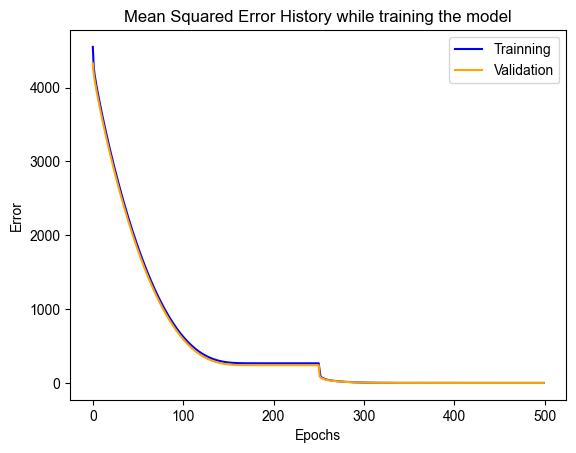

In [27]:
plt.plot(history.history['loss'],color='blue',label='Trainning')
plt.plot(history.history['val_loss'],color='orange',label='Validation')
plt.title('Mean Squared Error History while training the model')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
sns.set_style('whitegrid')
plt.show()

In [28]:
# Make predictions
predictions = model.predict(test_input)

151/151 [==============================] - 1s 2ms/step


In [29]:
predictions.shape

(4820, 1, 1)

In [30]:
test_soc.shape

(4820, 1)

In [31]:
test_soc = test_soc.reshape(4820,)
y_pred = predictions.reshape(4820,)

In [32]:
mse = mean_squared_error(test_soc, y_pred)
mae = mean_absolute_error(test_soc, y_pred)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(test_soc,y_pred)
r2 = r2_score(test_soc, y_pred)

In [40]:
print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape*100}')
print(f'R2 Score : {r2}')

Mean Squared Error on Test Set: 0.10242560551325021
Root Mean Squared Error on Test Set: 0.32004000611368916
Mean Absolute Error on Test Set: 0.26507121280021195
Mean Absolute Percentage Error on Test Set: 0.4630765066363357
R2 Score : 0.9996088035207754


In [34]:
print(f'Time taken for fitting the model is {a/60} mins')

Time taken for fitting the model is 5.119028214613596 mins


In [35]:
Residual = test_soc - y_pred

In [36]:
df = pd.DataFrame({'Actual': test_soc , 'Predicted': y_pred}).sort_values('Actual',ascending=False)
df.head()

,Actual,Predicted
1882,100.0,99.057739
1155,100.0,99.048920
2226,100.0,99.050690
4092,100.0,99.030701
4222,100.0,99.044373


In [37]:
df.tail()

,Actual,Predicted
123,4.0,2.625686
3346,4.0,3.448525
3919,4.0,3.627715
2266,3.0,2.911025
4732,2.0,1.737116


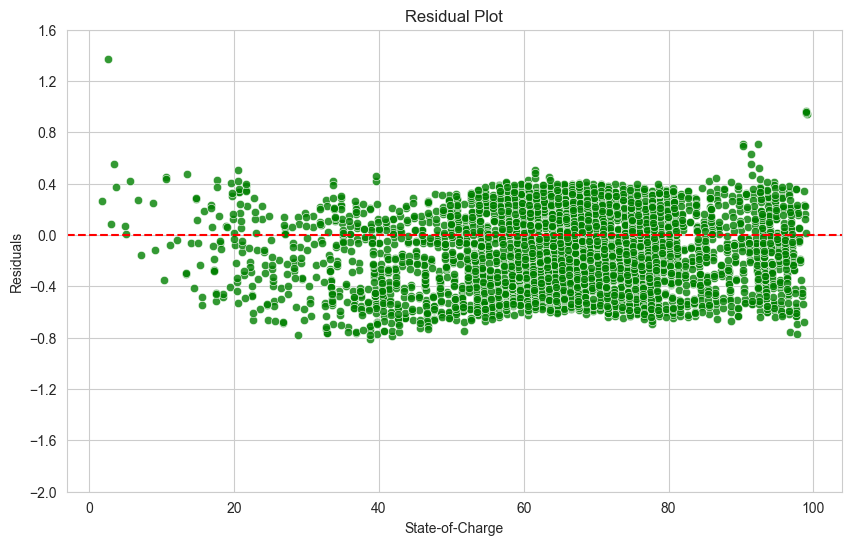

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=Residual, color='green', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('State-of-Charge')
plt.ylabel('Residuals')
plt.ylim(-1.6, 1)  # Set y-axis limits
plt.yticks([i * 0.4 for i in range(-5, 5)])  # Set y-axis ticks
plt.show()

In [39]:
# Save the model to a file
model.save("40deg.h5")